# Create ArcGIS webmap on perceptual-model database

I referred to Jessica's instruction to create this notebook https://github.com/jlembury/GEOG594-Embury/blob/master/DEMO_ArcGIS_API_Python.ipynb

## Import modules

In [1]:
import os
import webbrowser
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
import requests
import json

import arcgis
from arcgis.gis import GIS
from arcgis.features import FeatureLayerCollection
from arcgis.mapping import WebMap
from arcgis.geometry import Point, Polyline, Polygon, Geometry

## Connect with ArcGIS
Reference for authentication schemes: https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/

I ended up in using User autentification with OAuth 2.0 in Reference for authentication schemes: https://developers.arcgis.com/python/guide/working-with-different-authentication-schemes/

In [3]:
with open('./auth.json', 'r') as infile:
    my_credentials = json.load(infile)

In [8]:
gis = GIS("https://sdsugeo.maps.arcgis.com/", client_id=my_credentials['client_id'])
print("Successfully logged in as: " + gis.properties.user.username)
# Note: log-in expires after an hour or so 

# Clear the output for security 
from IPython.display import clear_output
clear_output(wait=False)

open

If you have ArcGIS pro, this is the most straightforward and easy connection

In [4]:
# gis = GIS('Pro')
# print("Logged in as " + str(gis.properties.user.username))

ImportError: The login failed because the arcpy library could not be found in your Python environment. Try logging in with a different set of credentials.

## Newly create a webmap (skip these blocks if you are updating)

In [7]:
# This section is to create a new webmap only
# Note: if this module says 'data already exist', skip to the section called 'Update to new data'

# Publish the CSV data to ArcGIS online
csv_path = "G:\\Shared drives\Perceptual model review\\ForRyoko\\perceptual-model-arcgis\\db_dev\\data\\giant_table_v4.csv"
csv_properties={'title':'figure_models_v4',
                'description':'Results of perceptual model analysis. Only for figure models',
                'tags':'perceptual_model'} # Use different title for the new data 
csv_item = gis.content.add(item_properties=csv_properties, data=csv_path)

print(csv_item)

RuntimeError: File(G:\Shared drives\Perceptual model review\ForRyoko\perceptual-model-arcgis\db_dev\data\giant_table_v4.csv) not found.

In [35]:
# Create and publich a feature layer from the CSV item
# Note: this automatically converts latitude and longitude to point geometry
feature_layer_item = csv_item.publish()
print(feature_layer_item)

<Item title:"figure_models_v4" type:Feature Layer Collection owner:raraki8159_SDSUGeo>


In [36]:
# Get feature layer id
feature_layer_id = feature_layer_item.id
print(feature_layer_id)
webbrowser.open('https://sdsugeo.maps.arcgis.com/apps/mapviewer/index.html?layers={}'.format(feature_layer_id), new=2)

added_item = gis.content.get(feature_layer_id)

31d8645bf557479085b53a5f473c6c8f


In [37]:
# Create a webmap from the feature layers 

# Initialize map widget
webmap = gis.map()

# Set an map extent (global)
webmap.extent = {'xmin': -140,
                'ymin':-50,
                'xmax':180,
                'ymax':65,
                }

# Add the created layer
webmap.add_layer(added_item)

# Save the webmap
webmap_properties = {'title':'Perceptual Models Around the World',
                    'snippet': 'description',
                    'tags':'perceptual_model'}

webmap_item = webmap.save(webmap_properties)

# Display the webmap
webmap_item_id = webmap_item.id
print(webmap_item_id)
webbrowser.open('https://sdsugeo.maps.arcgis.com/apps/mapviewer/index.html?webmap={}'.format(webmap_item_id), new=2)
webmap_item

b1d0582ade934e81930bed22eb685504


<Item title:"Perceptual Models Around the World" type:Web Map owner:raraki8159_SDSUGeo>

## Updating the existing webmap with new data

<Item title:"figure_models_v4" type:Feature Layer Collection owner:raraki8159_SDSUGeo>
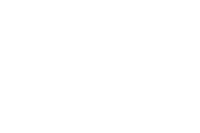

In [5]:
# Only for updates in values or new entries, no structural changes allowed
# Get existing layer
feature_layer_id = '31d8645bf557479085b53a5f473c6c8f'
existing_item = gis.content.get(feature_layer_id)
existing_item

In [6]:
# Overwrite with new data
new_data = "G:\\Shared drives\Perceptual model review\\ForRyoko\\perceptual-model-arcgis\\dev\\data\\giant_table_v4.csv"
overwrite_layer = FeatureLayerCollection.fromitem(existing_item)
overwrite_layer.manager.overwrite(new_data)

{'success': True}

In [7]:
# Check the updates 
updated_feature = gis.content.get(feature_layer_id)
webbrowser.open('https://sdsugeo.maps.arcgis.com/apps/mapviewer/index.html?layers={}'.format(feature_layer_id), new=2)

webmap_item_id = "b1d0582ade934e81930bed22eb685504"
webbrowser.open('https://sdsugeo.maps.arcgis.com/apps/mapviewer/index.html?webmap={}'.format(webmap_item_id), new=2)

True

## Adjust display of webmap (need to run only after creating a new map)

In [42]:
def get_map (map_id):
    '''
    GET MAP DATA FOR CHANGES
    '''
    
    m = gis.content.get(map_id)

    data = m.get_data()
    
    #Include the below line for prettified JSON
    #print(json.dumps(data, indent=4, sort_keys=True))

    print(m)
    
    return data
    
def update_map (map_id, data):
    '''
    UPDATE MAP TO SAVE CHANGES
    '''
    m = gis.content.get(map_id)
    
    # Set the item_properties to include the desired update
    properties = {"text": json.dumps(data)}

    # 'Commit' the updates to the Item
    update = m.update(item_properties=properties)
    
    return update

In [43]:
webmap_item_id = 'b1d0582ade934e81930bed22eb685504'
webmap_data = get_map(webmap_item_id)
print(json.dumps(webmap_data, indent=4, sort_keys=True))

<Item title:"Perceptual Models Around the World" type:Web Map owner:raraki8159_SDSUGeo>
{
    "authoringApp": "ArcGISPythonAPI",
    "authoringAppVersion": "2.0.1",
    "baseMap": {
        "baseMapLayers": [
            {
                "layerType": "ArcGISTiledMapServiceLayer",
                "resourceInfo": {
                    "capabilities": "Map,Tilemap,Query,Data",
                    "currentVersion": 10.3,
                    "exportTilesAllowed": false,
                    "fullExtent": {
                        "spatialReference": {
                            "latestWkid": 3857,
                            "wkid": 102100
                        },
                        "xmax": 20037507.067161843,
                        "xmin": -20037507.067161843,
                        "ymax": 19971868.88040863,
                        "ymin": -19971868.880408604
                    },
                    "initialExtent": {
                        "spatialReference": {
             

In [44]:
# Make some changes

# Change the display names 
mylabel_dict = {0:{"fieldName":"id","label":"Model ID","visible":False},
                1:{"fieldName":"citation","label":"Citation","visible":False},
                2:{"fieldName":"url","label":"URL","visible":False},
                3:{"fieldName":"attribution","label":"Attribution","visible":False},
                4:{"fieldName":"attribution_url","label":"Attribution link","visible":False},
                5:{"fieldName":"figure_num","label":"Figure number","visible":False},
                6:{"fieldName":"figure_caption","label":"Figure caption","visible":False},
                7:{"fieldName":"figure_url","label":"Figure URL","visible":False},
                8:{"fieldName":"watershed_name","label":"Watershed name","visible":True},
                9:{"fieldName":"lat","label":"latitude","visible":False},
                10:{"fieldName":"lon","label":"longitude","visible":False},
                11:{"fieldName":"area_km2","label":"longitude","visible":False},
                12:{"fieldName":"huc_watershed_id","label":"US HUC8","visible":False},
                13:{"fieldName":"num_spatial_zones","label":"Number of spatial zones","visible":True},
                14:{"fieldName":"spatial_property","label":"Spatial property","visible":True},
                15:{"fieldName":"num_temporal_zones","label":"Number of temporal zones","visible":True},
                16:{"fieldName":"temporal_property","label":"Temporal property","visible":True},
                17:{"fieldName":"vegetation_info","label":"Vegetation","visible":True},
                18:{"fieldName":"soil_info","label":"Soil","visible":True},
                19:{"fieldName":"geol_info","label":"Geology","visible":True},
                20:{"fieldName":"topo_info","label":"Topography","visible":True},
                21:{"fieldName":"three_d_info","label":"3-dimensional description","visible":True},
                22:{"fieldName":"uncertainty_info","label":"Uncertainty range","visible":True},
                23:{"fieldName":"other_info","label":"Information: other","visible":True},
                24:{"fieldName":"num_store","label":"Number of stores","visible":True},
                25:{"fieldName":"store_list","label":"List of stores","visible":True},
                26:{"fieldName":"store_id_list","label":"Hashtags of stores","visible":True},
                27:{"fieldName":"num_flux","label":"Number of fluxes","visible":True},
                28:{"fieldName":"flux_list","label":"List of fluxes","visible":True},
                29:{"fieldName":"flux_id_list","label":"Hashtags of fluxes","visible":True},
                30:{"fieldName":"dummy_column","label":"dummy_column","visible":False},
                31:{"fieldName":"ObjectId","label":"ObjectID","visible":False}
               }

for i in range(len(mylabel_dict)): 
    if webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['fieldName'] == mylabel_dict[i]['fieldName']:
        print('The dictionary is in correct order')
        
        print(webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['label'])
        webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['label'] = mylabel_dict[i]['label']
        print(webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['label'])

        print(webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['visible'])
        webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['visible'] = mylabel_dict[i]['visible']
        print(webmap_data['operationalLayers'][0]['popupInfo']['fieldInfos'][i]['visible'])
    else:
        print('The dictionary is in wrong order')

The dictionary is in correct order
id
Model ID
True
False
The dictionary is in correct order
citation
Citation
True
False
The dictionary is in correct order
url
URL
True
False
The dictionary is in correct order
attribution
Attribution
True
False
The dictionary is in correct order
attribution_url
Attribution link
True
False
The dictionary is in correct order
figure_num
Figure number
True
False
The dictionary is in correct order
figure_caption
Figure caption
True
False
The dictionary is in correct order
figure_url
Figure URL
True
False
The dictionary is in correct order
watershed_name
Watershed name
True
True
The dictionary is in correct order
lat
latitude
True
False
The dictionary is in correct order
lon
longitude
True
False
The dictionary is in correct order
area_km2
longitude
True
False
The dictionary is in correct order
huc_watershed_id
US HUC8
True
False
The dictionary is in correct order
num_spatial_zones
Number of spatial zones
True
True
The dictionary is in correct order
spatial_

In [45]:
# Update the icon to prettier one
webmap_data['operationalLayers'][0]['layerDefinition']['drawingInfo']['renderer']['symbol']['url'] = "https://static.arcgis.com/images/Symbols/Government/Water-Teatment-Plant-Permit.png"
webmap_data['operationalLayers'][0]['layerDefinition']['drawingInfo']['renderer']['symbol']['imageData'] = "iVBORw0KGgoAAAANSUhEUgAAAHkAAAB5CAYAAAAd+o5JAAAAAXNSR0IArs4c6QAAAARnQU1BAACxjwv8YQUAAAAZdEVYdFNvZnR3YXJlAEFkb2JlIEltYWdlUmVhZHlxyWU8AAANaElEQVR4Xu2dz+ocSxXH5xHyCFncB3DhA+QRcsGFMYhXXIgIchERcZUr4kZuQlAQFMniigsRIiiCoAQMuhAuP0TuwoWKIOJCjKBwFy7G+aSmfulfzzmnqk6d6p6ZzBe+/Eimu7qqTp+/Vd29ueCC08D9x7d3vLPjgx2f7Phsz20D8zmPdqSdOzve3l/hgsXxSqAI5cWOktCiSPtcJwn+gkG4//jWjm/t+HTziUf/2f2VhLEM0/Wf7kh/bu17eIEbWbDSZB8Pk8AvaEDyr/jF0WY4mvSXfl/8uAr83b1339tPmI+f+s5285nvbzef++F28/kfbTdf+Ml288Wfl/n2T9PxnMf5tCO1X8s0jov/vsbHvvHR3YS0RsKJCAThIKivPNtuvvrrONIe7dI+15GuX+azl+N7bZHMMumONDky0TC0jcmXBDOaXJfrt2s643zNzHhKR+p87ie/vd189r3t5ku/kCd+LdIf+kX/pH4fkvE+2M/AGQPTde/hH2aDl/np7yafGm2Go0n/6GetdjP+szXhH3/36+Kg58T/rWWOe0m/a/0383E2ePOdN3aDujoY5JynLNw564V99XJ+Thr3H9/d0fa9+DTMnTRZp07GVfbZzM/d/YydGFJwJQ3qFYlUj93n9pLxMU5p/Dd5YkFZKTUiSDkX01xLxlsOzp7sZ/CIQcH+3sPns47fJGnHuWuvRsbN+KV5yUzzd6QLH2mlSA+wztn3trLsq5nHIxN0jYBXLGZ85Fvvb+987/cHvP3N34nHL0Lm42QEXRIwRY0FzPOtr/32peAe/Oqv26cf/HN79ff/blvw7M//fnke59OOdI1wMi/MjzRviUciaMsHDxYwGvroN39rFmgtEPzbP/vTWI0vCZr5XRVWFE2AIQ2qk0w42vaXf324F8Uy4EZC4FgMqV/dtAOylaJuKw8eIGBM6JP3/7Gf8nVBP4Zoty3ohfPoVMmSOpJMjzQAJxEuZvMYMUTYto9eqDKWatFyqTLQBzN5x6K5JeA+wsy47aNfLFPr1iJp0oHAIIuJ6wE+NEfL8O4PPnhpFTLf+vEfr3/DUvT6eM6nXWkszWQe9fTqai+JQdCWCwflwQiiFggVgfVMdE7DeiJ2zg3RaiuPHrZMmfZiyRcdWMmyBJ0j3lEpjjeSp1+kd1KbTWRepfmGQzYeaDs6BqVKU2J2p8BXh5nGSmLuWwLAFx/+L6aPWsSNPEKhpUusqgT6YY1oFGCSR2ltLRFciynHEkntVJP51VevgtKqtKtSjqYXXC5cW7hz4ibQ1hp0C5p5luY/ySVgF6hW1WIhXOpQIwlSMIUELNLvx0z6PnclGroFrW886KyGacFWR7o0Ferc7EnHnwLR6hp0CdpKq7qCMO3JhoZo2hLqHNL50cSvS//fS6LpGvPdFXXr0fazvcQakZ4BPmyQXYhSByasFeocUluRpF+Av9LvvUSApXSLG6ErvtB3gTqevdIePhOCLSLOXDnqwbzdaOb+4Uel3yOI5Srd3PwunVtFLQhDXk1IEfVhQ3stjhLqHAcDCiRaNsXIaB1Bl0x3V6Cpa3NDpJ2esz1sZHcX1dypXogDCuJ8sYObVDouijU+2l0s0VOqR3sJVkDKi0nIJxfiTozGtP1I5mLKFAhAOjaSCNEC/ls6r4pygeTFXoIFpFc4HDYgRNQEMDURZS3m7UcRrZXQnbtWULt2htui6JF2xastpHd0kJ9JF9oRLYky31L7vbT8Y5cmNdCKXegbfZTOM6nnzU/3klSQdl4enlixCBFhvqV2e4m2WnD7xQaiCJbFc2uzvl3I2OGpmerKteJe8y212ctS3joynZrSMttubUYukrxMky2Z6lnAVWKP+Zba62FJizNGplNTWjecW5vlAMww2dKL0BwLEVI0WwOprR7W5vGkV9L50bRuOrRZOqdIaeECOYrQyphChavEUkSpQWrLy1L6MofLXDpoabMr2tdzZqHMqW0MkBousOQHNUhtedlajXOby0Za2uyODyS5iRsKpBWnisWIOeflwxZI7XnocRfu4KeRVkoHXH2Qy5zCypRU5eJFZVKjBq1UijvVGqDUnofe/dqsC0vtRdPqn8tkI6e57A6qX9qChMMfW5E1dymarh0jtddKb9AHliqO5CVPCa4gUPfLkwULLehq3P2BEDXgI6fHSXfztC0vvVqc4dIkBzWL5rrRkJMkvxvBlxR0NebH0LpDJVPIhE4HO/+9lT1anLGUNlt7w1x5u5wvT4IvaWnREXRZqRNmWjqH/8/RuPR7C3u1OGMJbbb2hbl2rsjB12TpUYqsHUUQK22Rjs/EfPeWFyO0OGMJbbayEFc6J+/mnETYkpAdkXXWyDmm/ngUo7Q4Ywlt1uC64eUI+4aQDw/gRd9SYwY1uCLGBkZqccYS2qxlGS6l0NaXryH92Jg+WRM9upoUrcUZo/utuTeCUel4k1oadQ3px0YhW7XikUWGEVqcwWS7KlCVtApH0vEm1xbyyIX5UVqcMVKbrWxEOt7kuQoZLbPKpBEY6ZvXF/KXfyk3pnANIVuTFIlRkfZFkyuopWzRIAqWrt/Li5ALtEqoI6BV7Hp4VkIeEV2PDrjm6HqsRaE1Bul4k0sI2VqB4o6Vzunh6IBrjhEBmJYnu67lEnLDM8iZGqIrXlbddyRcq0MGtZhiVMXrpGrXRLtrwLU6ZFCDSykqaterrkK1cqnUaY5It2PFMK7rVKxCHb78ZaH1ZA/PQchrrCevsjPEy3MQsrUzxFUvr9gZcmf2Y2LjHi9rsSDSL1taMBKRlS8Nrsi6co/XYrs1pXNaafmzkYgq6lgWzxV0aenTweslFth3HaUJVk4+ElJfPLRMtcsfy5G18NYBKcJ2BF9WDhtZA7YsxghEuRvrBnVtFoBy0CU+QbHIs1BRJm9pvxwVOFpBo7toJMntRtCVoQVfDr9sDaR3V2bmyB0hc5R2iDCmmniDY6xyrEsBdH+svLxtoeeTo3Jmq8AfiVLqBLBepXFZN78rqoZSEUR9PhkEvGkg0wouovwbN9PohYqSFsMptOCypMXuoFTOj403DXS+M2TKUpoTVQce7Ztr+jkHFmZ+Y1hWp+ZGEul8Z4j77T8SrVo25sk1MIGjzHbtGrIEov9svks3vLuS5nr7D5BMtvP91qXBRS7ER6dULZGuBjQUS2NlG+6bHXm43uMFNJPtWF+GJS2LMttMVJRGt958PXCPv+uNfECqfjk/z8fkWwEHv0WuUKE51vUscJ5n0r3oCkDlgKvy3ZrAeEuueMECS8FRpH+GRN0tWo1w8YvePnjANemn1F6Rem7c9JZc833XHlopFcCnRgoa0h6pCQJHa7KG85d/Y5Yj3IUHXRU0uYwJG78s0/Dm+hoy4VYAAkYIegl6wFhdmqxpcfOb64FW5uzQZmvxIuMUBe2FKwbQtdjxDQogrUxBZ6QNMZ8loPGRwdho9qI6mtcjamHFqRYDvgsFa6pU3OVR68+jGYGi+dbz4oCPcw76wltt9Fu7wrMmo2Cab3k3Juz8whtIkfZh3gydQVhmraCPXaujcWC+9ZQJuQR8qxFoGwpIyDvMNqwx3RmkPVGbDiI5AtcBKPMrFz5g0FdXMwZ+PxktRVtrgbCPSbMjwdgozFzfzNoiRPj3k4EWhMGOaDuTaLqUR8/B8Zi2UZE4/rHGcvTgQKhT6tH0oC+hA76lL12QqM+x5jwn5qlUGdOQBY5gvOVCbhYsBLFCtiw1y4AtMIU6JfOpRdPIYSjuP746uCjsTKumRFAt5lsC5zOh3DRMqkaOgRo4RurjlBaqhTqllS4x/8Px5jtv7C4kR9usVAUJGq1GM9dGq5AJmLJFkY4tkvljHqX5Zd6Z/0Vw//Hd2cVf0bkkqbF1RSkaXFvq15RZqCH5vC5geHcvgYWgpVUwIOKeMwu714y3Al8v9WcI9e08MDhdqoVWDYMDBA3RFoIjzOJSWKSObgs4oKrVg3sPnwudSgz00RLRboopBFfRGo4GYzm4oULMsEbbB5MPP9/P9IpIOzzliBsOFvSUOQXCRxLV1mp7jrAJsnpSsGaWBJzmtbDzcimUBB2UR58VrTw48YgEnFEj6IDK2FmQeTg5AWfQMctHQwKMhcz30ZFx2wFW8sFHK+AprKgbsqrSuUx5cmS8+mpS5spRdCusPDqThfBz12rGpy/4T7lSHtyLVBmTS6CZ5+yry74XMj8LV7KikWrdekCWyS7EczHhjMNOjTKvlqtFLwFtmXLOUxY2/da3zN7k8OXCtcBCt7bDZE6CFMzdsfts+kc/y0FVIuMftuB/TEhBme2rM/FppB3HVkyhP/Sr7HMzGe+JBldepF2gdqo1J9pCpLqWOee6XL9Wa1+RcQbtqjxFpL1j8pMaJeL/eFEZkx9t1mmPdmm/1s8e8tnrYZprwbM82kN2tUTDEAjahnDwlQiqRI7jeM7j/HZNvck0DuezSa8Dkhnn+eg6n308pL/0+zU2yx6kV1scvsPkuEj/Kl/hcIGOtMKVBC69UG5JpusnwZ7EQsKpIj07TRpGwDbarNM+1+F6Fz+7GpIfv7MXBH4RobRG7Pkczk8CvfjXC04Dm83/AZ9peMb+hNWWAAAAAElFTkSuQmCC"

In [46]:
# Turn off the layer name
webmap_data['operationalLayers'][0]['popupInfo']['title'] = ""

In [51]:
# Update the basemaps

# US HUC8 layer 
HUC8_dict = {
                "id": "183343475b2-layer-50",
                "itemId": "988c850f4c944d53bd29bd934dd6ac22",
                "layerType": "ArcGISMapServiceLayer",
                "opacity": 0.25,
                "title": "Watershed Boundary Dataset (WBD) from NHDPlus Version 2.1 (Simplified/Nested), EPA OW",
                "url": "https://watersgeo.epa.gov/arcgis/rest/services/NHDPlus_NP21/WBD_NP21_Simplified/MapServer"
            }

# World waterbody maps
river_dict = {
                "id": "1830ae1b2b9-layer-53",
                "itemId": "9f86716d941c4410b0b406d911754b2c",
                "layerType": "ArcGISTiledMapServiceLayer",
                "title": "Esri Hydro Reference Overlay",
                "url": "https://tiles.arcgis.com/tiles/P3ePLMYs2RVChkJx/arcgis/rest/services/Esri_Hydro_Reference_Overlay/MapServer",
                "visibility": True
            }

webmap_data['baseMap']['baseMapLayers'].append(HUC8_dict)
webmap_data['baseMap']['baseMapLayers'].append(river_dict)

In [48]:
# Change the pop-ups
webmap_data['operationalLayers'][0]['popupInfo']['popupElements'] = [
                    {
                        "text": "<p><span style='font-size:18px;'>A perceptual model of<strong> {watershed_name}&nbsp;</strong></span></p>",
                        "type": "text"
                    },
                    {
                        "description": "",
                        "mediaInfos": [
                            {
                                "altText": "",
                                "caption": "Caption: {figure_caption};&nbsp<a href='{url}' rel='nofollow ugc' target='_blank'>From Figure {figure_num} in {citation}</a>;&nbsp<a href='{attribution_url}' rel='nofollow ugc' target='_blank'>{attribution}</a>",
                                "refreshInterval": 0,
                                "title": "",
                                "type": "image",
                                "value": {
                                    "linkURL": "{url}",
                                    "sourceURL": "{figure_url}"
                                }
                            }
                        ],
                        "title": "",
                        "type": "media"
                    },
                    {
                        "text": "<p>\u25bc Process information in the model</p>",
                        "type": "text"
                    },
                    {
                        "description": "",
                        "fieldInfos": [
                            {
                                "fieldName": "num_store",
                                "isEditable": True,
                                "label": "Number of stores",
                                "visible": True
                            },
                            {
                                "fieldName": "store_list",
                                "isEditable": True,
                                "label": "List of stores",
                                "visible": True
                            },
                            {
                                "fieldName": "store_id_list",
                                "isEditable": True,
                                "label": "Hashtags of stores",
                                "visible": True
                            },
                            {
                                "fieldName": "num_flux",
                                "isEditable": True,
                                "label": "Number of fluxes",
                                "visible": True
                            },
                            {
                                "fieldName": "flux_list",
                                "isEditable": True,
                                "label": "List of fluxes",
                                "visible": True
                            },
                            {
                                "fieldName": "flux_id_list",
                                "isEditable": True,
                                "label": "Hashtags of fluxes",
                                "visible": True
                            }
                        ],
                        "title": "",
                        "type": "fields"
                    },
                    {
                        "text": "<p>\u25bc Spatio-temporal heterogeneity in the model</p>",
                        "type": "text"
                    },
                    {
                        "description": "",
                        "fieldInfos": [
                            {
                                "fieldName": "num_spatial_zones",
                                "isEditable": True,
                                "label": "Number of spatial zones",
                                "visible": True
                            },
                            {
                                "fieldName": "spatial_property",
                                "isEditable": True,
                                "label": "Spatial property",
                                "visible": True
                            },
                            {
                                "fieldName": "num_temporal_zones",
                                "isEditable": True,
                                "label": "Number of temporal zones",
                                "visible": True
                            },
                            {
                                "fieldName": "temporal_property",
                                "isEditable": True,
                                "label": "Temporal property",
                                "visible": True
                            }
                        ],
                        "title": "",
                        "type": "fields"
                    },
                    {
                        "text": "<p>\u25bc Ancillary information in the model</p>",
                        "type": "text"
                    },
                    {
                        "description": "",
                        "fieldInfos": [
                            {
                                "fieldName": "vegetation_info",
                                "isEditable": True,
                                "label": "Vegetation",
                                "visible": True
                            },
                            {
                                "fieldName": "soil_info",
                                "isEditable": True,
                                "label": "Soil",
                                "visible": True
                            },
                            {
                                "fieldName": "geol_info",
                                "isEditable": True,
                                "label": "Geology",
                                "visible": True
                            },
                            {
                                "fieldName": "topo_info",
                                "isEditable": True,
                                "label": "Topography",
                                "visible": True
                            },
                            {
                                "fieldName": "uncertainty_info",
                                "isEditable": True,
                                "label": "Uncertainty range",
                                "visible": True
                            },
                            {
                                "fieldName": "three_d_info",
                                "isEditable": True,
                                "label": "3-dimensional description",
                                "visible": True
                            }
                        ],
                        "title": "",
                        "type": "fields"
                    },
                    {
                        "text": "<p>\u25bc Watershed information</p>",
                        "type": "text"
                    },
                    {
                        "description": "",
                        "fieldInfos": [
                            {
                                "fieldName": "area_km2",
                                "isEditable": True,
                                "label": "Watershed area (km2)",
                                "visible": True
                            },
                            {
                                "fieldName": "huc_watershed_id",
                                "isEditable": True,
                                "label": "US HUC8 watershed ID",
                                "visible": True
                            }
                        ],
                        "title": "",
                        "type": "fields"
                    }
                ]

In [52]:
# Update the map
webmap_update = update_map(webmap_item_id, webmap_data)
webmap_update

True

In [53]:
# Verify changes updated
webbrowser.open('https://sdsugeo.maps.arcgis.com/apps/mapviewer/index.html?webmap={}'.format(webmap_item_id), new=2)

# https://sdsugeo.maps.arcgis.com/apps/mapviewer/index.html?webmap=e535103892fd41cd915d60ca4d1d9d44

True